This notebook plots cell responses during tone presentations for all cells across days.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

if os.environ['SHELL'] == '/bin/zsh':  # Laptop/Mac
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/sh', '/bin/bash']:  # Linux desktop
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces, Raster, RasterGroup
from neuropy.io.minianio import MinianIO
import session_directory as sd
from neuropy.analyses.trace_fc import load_events_from_csv
from neuropy.core.ca_neurons import CaNeuronReg, PairwiseMap, MultiSessionMap, CaNeurons, load_pairwise_map
from neuropy.utils.plot_util import sparse_axes_labels
from traceio import load_trace_events

/home/nkinsky/miniconda3/envs/NeuroPy/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniconda3/envs/NeuroPy/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import itertools

# Specify sessions to plot here
animal = 'Finn' #'Jyn' # 'Rat698' # 'Rose' # 'Rey' 
sessions = ['Habituation2', 'Training', 'Recall1', 'Recall1']
sesh_types = ['tone_habituation', 'training', 'tone_recall', 'control_tone_recall']
CS_types = ['CS+', 'CS+', 'CS+', 'CS-']
keep = [['good', 'maybe_interneurons']]*len(sessions)
trim = [None]*len(sessions)

if animal == 'Finn':
    for idt in np.where([sesh == 'Training' for sesh in sessions])[0]:
        keep[idt] = None
        trim[idt] = 'bad_units'  
    
# Assemble data
careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).trim_neurons(keep=ke, trim=tr) 
                     for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)


Eliminating timestamps from corrupted video8 in 13_16_31 folder.
Keeping 38506 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video18 in 12_49_22 folder.
Keeping 125447 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file


In [3]:
activity_type = 'C'
sortby = "peak_time" # "peak_time" or "trough_time"
start_buffer, end_buffer = 10.0, 40.0
rastgroups = []
for sesh_name, sesh_type, CS_type in zip(sessions, sesh_types, CS_types):
    
    try:
        event_starts, event_ends = load_trace_events(sd.get_session_dir(animal, sesh_name), 
                                                     sesh_type, CS_type)
        rastgroups.append(RasterGroup(getattr(careg.get_session(sesh_name), activity_type), 
                                      careg.get_session(sesh_name).t['Timestamps'], 
                                      event_starts['Timestamp'], 
                                      event_ends['Timestamp'], 
                                      cell_ids=None, 
                                      start_buffer_sec=start_buffer, 
                                      end_buffer_sec=end_buffer))
    except ValueError: # Should catch any errors due to missing sessions for Rat698
        rastgroups.append(None)



In [173]:
map_use2 = msm.grab_map(['Habituation2', 'Training'], coactive_only=False)

In [174]:
map_use2.loc[map_use['Habituation2'].values]

,Habituation2,Training
1,1,-1
2,2,14
9,9,-1
10,10,17
12,12,21
13,13,-1
15,15,22
17,17,19
18,18,27
19,19,29


In [172]:
map_use.loc[map_use['Habituation2'].values]

,Habituation2,Recall1
1,1,4
2,2,6
9,9,9
10,10,11
12,12,16
13,13,15
15,15,17
17,17,18
18,18,20
19,19,21


In [168]:
map_use['Habituation2'].values

array([ 1,  2,  9, 10, 12, 13, 15, 17, 18, 19, 21, 24, 25, 26, 28])

/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:473: RuntimeWarning: invalid value encountered in true_divide
  sorted_mean_rast = sorted_mean_rast / sorted_mean_rast.max(axis=1)[:, None]


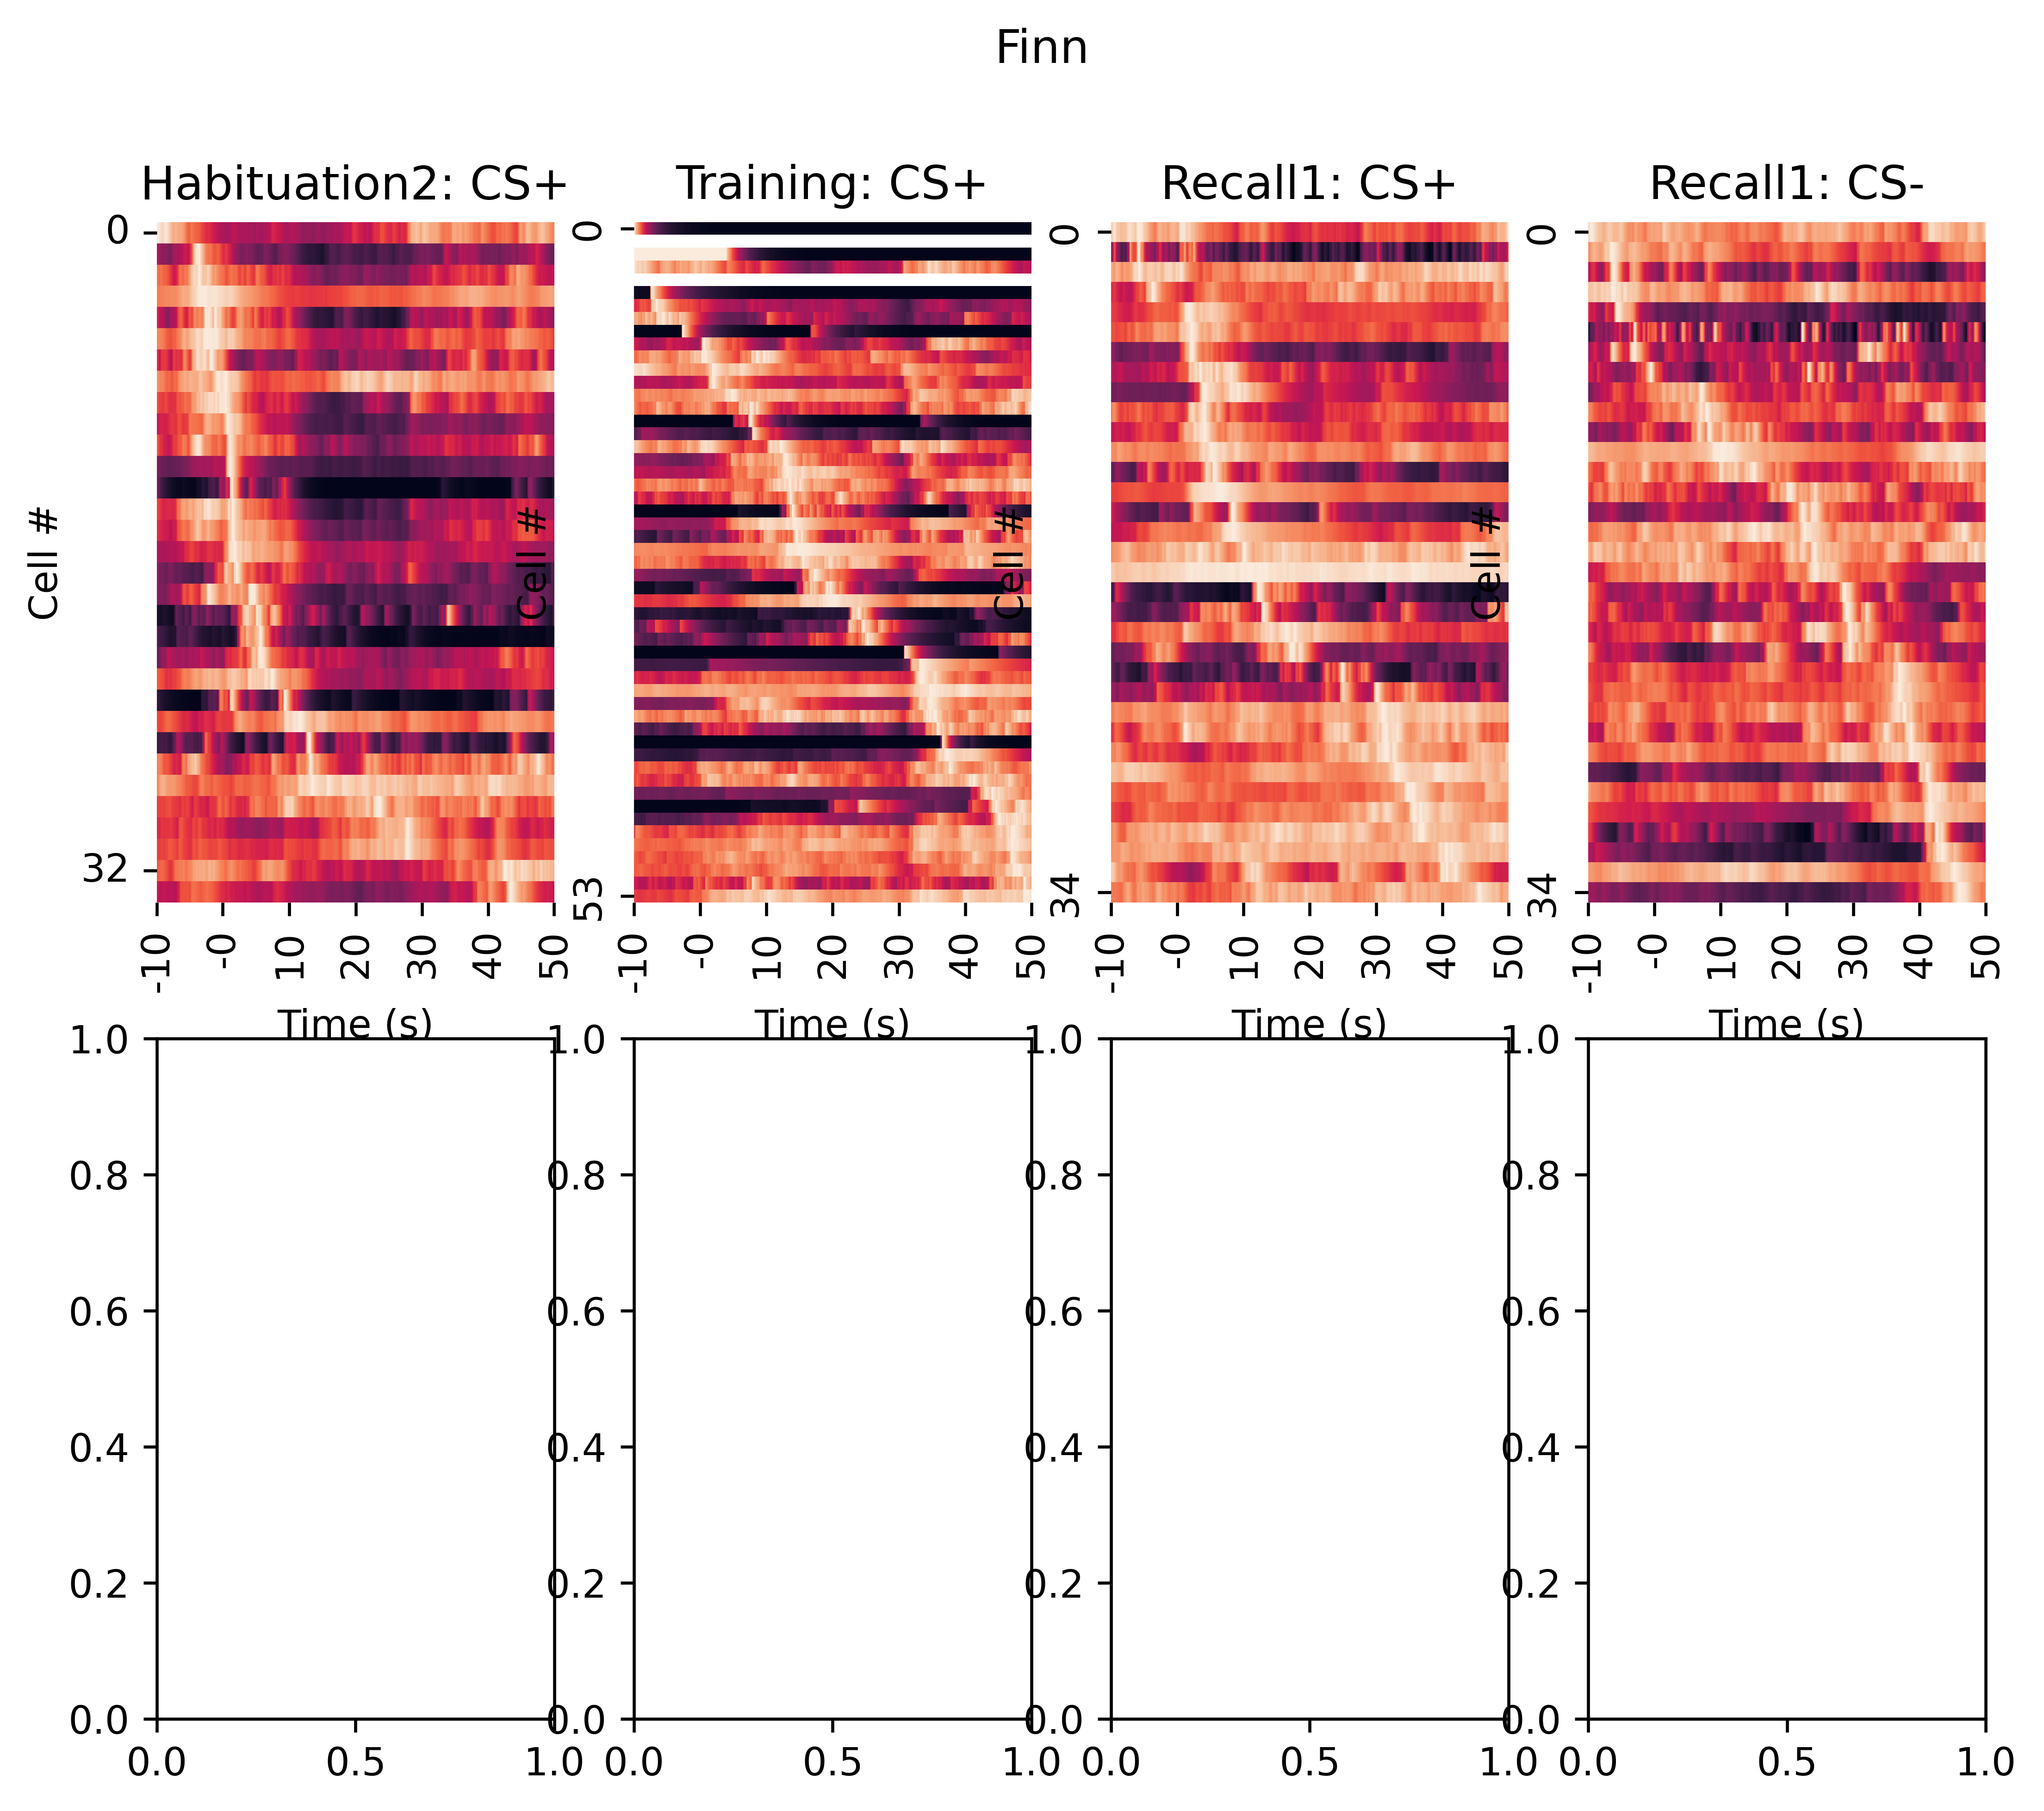

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(8.5, 7), dpi=600)
fig.suptitle(animal)
sort_ids = []  # keep track of how you sorted things
for a, rgroup, sesh_name, CStype in zip(ax[0], rastgroups, sessions, CS_types):
    if rgroup is not None:
        ids = rgroup.snake_plot(sortby=sortby, ax=a, cbar=False, rasterized=True)
        sort_ids.append(ids)
        a.set_title(f"{sesh_name}: {CStype}")

In [5]:
# Quick and dirty way to plot sessions sorted the same way - need to update to use
# registration maps. This only works for recall sessions where you have all neurons
# sorted together the same way.
recall_sesh = 'Recall1'  # name of recall session to plot
same_ids = np.where([sesh_name == recall_sesh for sesh_name in sessions])[0]
off_ids = np.where([sesh_name != recall_sesh for sesh_name in sessions])[0]
label_id = same_ids[0] - 1 if same_ids[0] > 0 else same_ids[1] + 1

In [6]:
# Plot Recall1 sessions sorted together
sort_id = sort_ids[same_ids[0]]
for sid in same_ids:
    a = ax[1][sid]
    rgroup = rastgroups[sid]
    sesh_name, CStype = sessions[sid], CS_types[sid]
    rgroup.snake_plot(sortby=sort_id, ax=a, cbar=False, rasterized=True)
    
ax[1][label_id].text(0.5, 0.3, 'Same Sorting', rotation='vertical')
[a.axis('off') for a in ax[1][off_ids]]

/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sortby == "peak_time" or sortby == "trough_time":


[(0.0, 1.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0)]

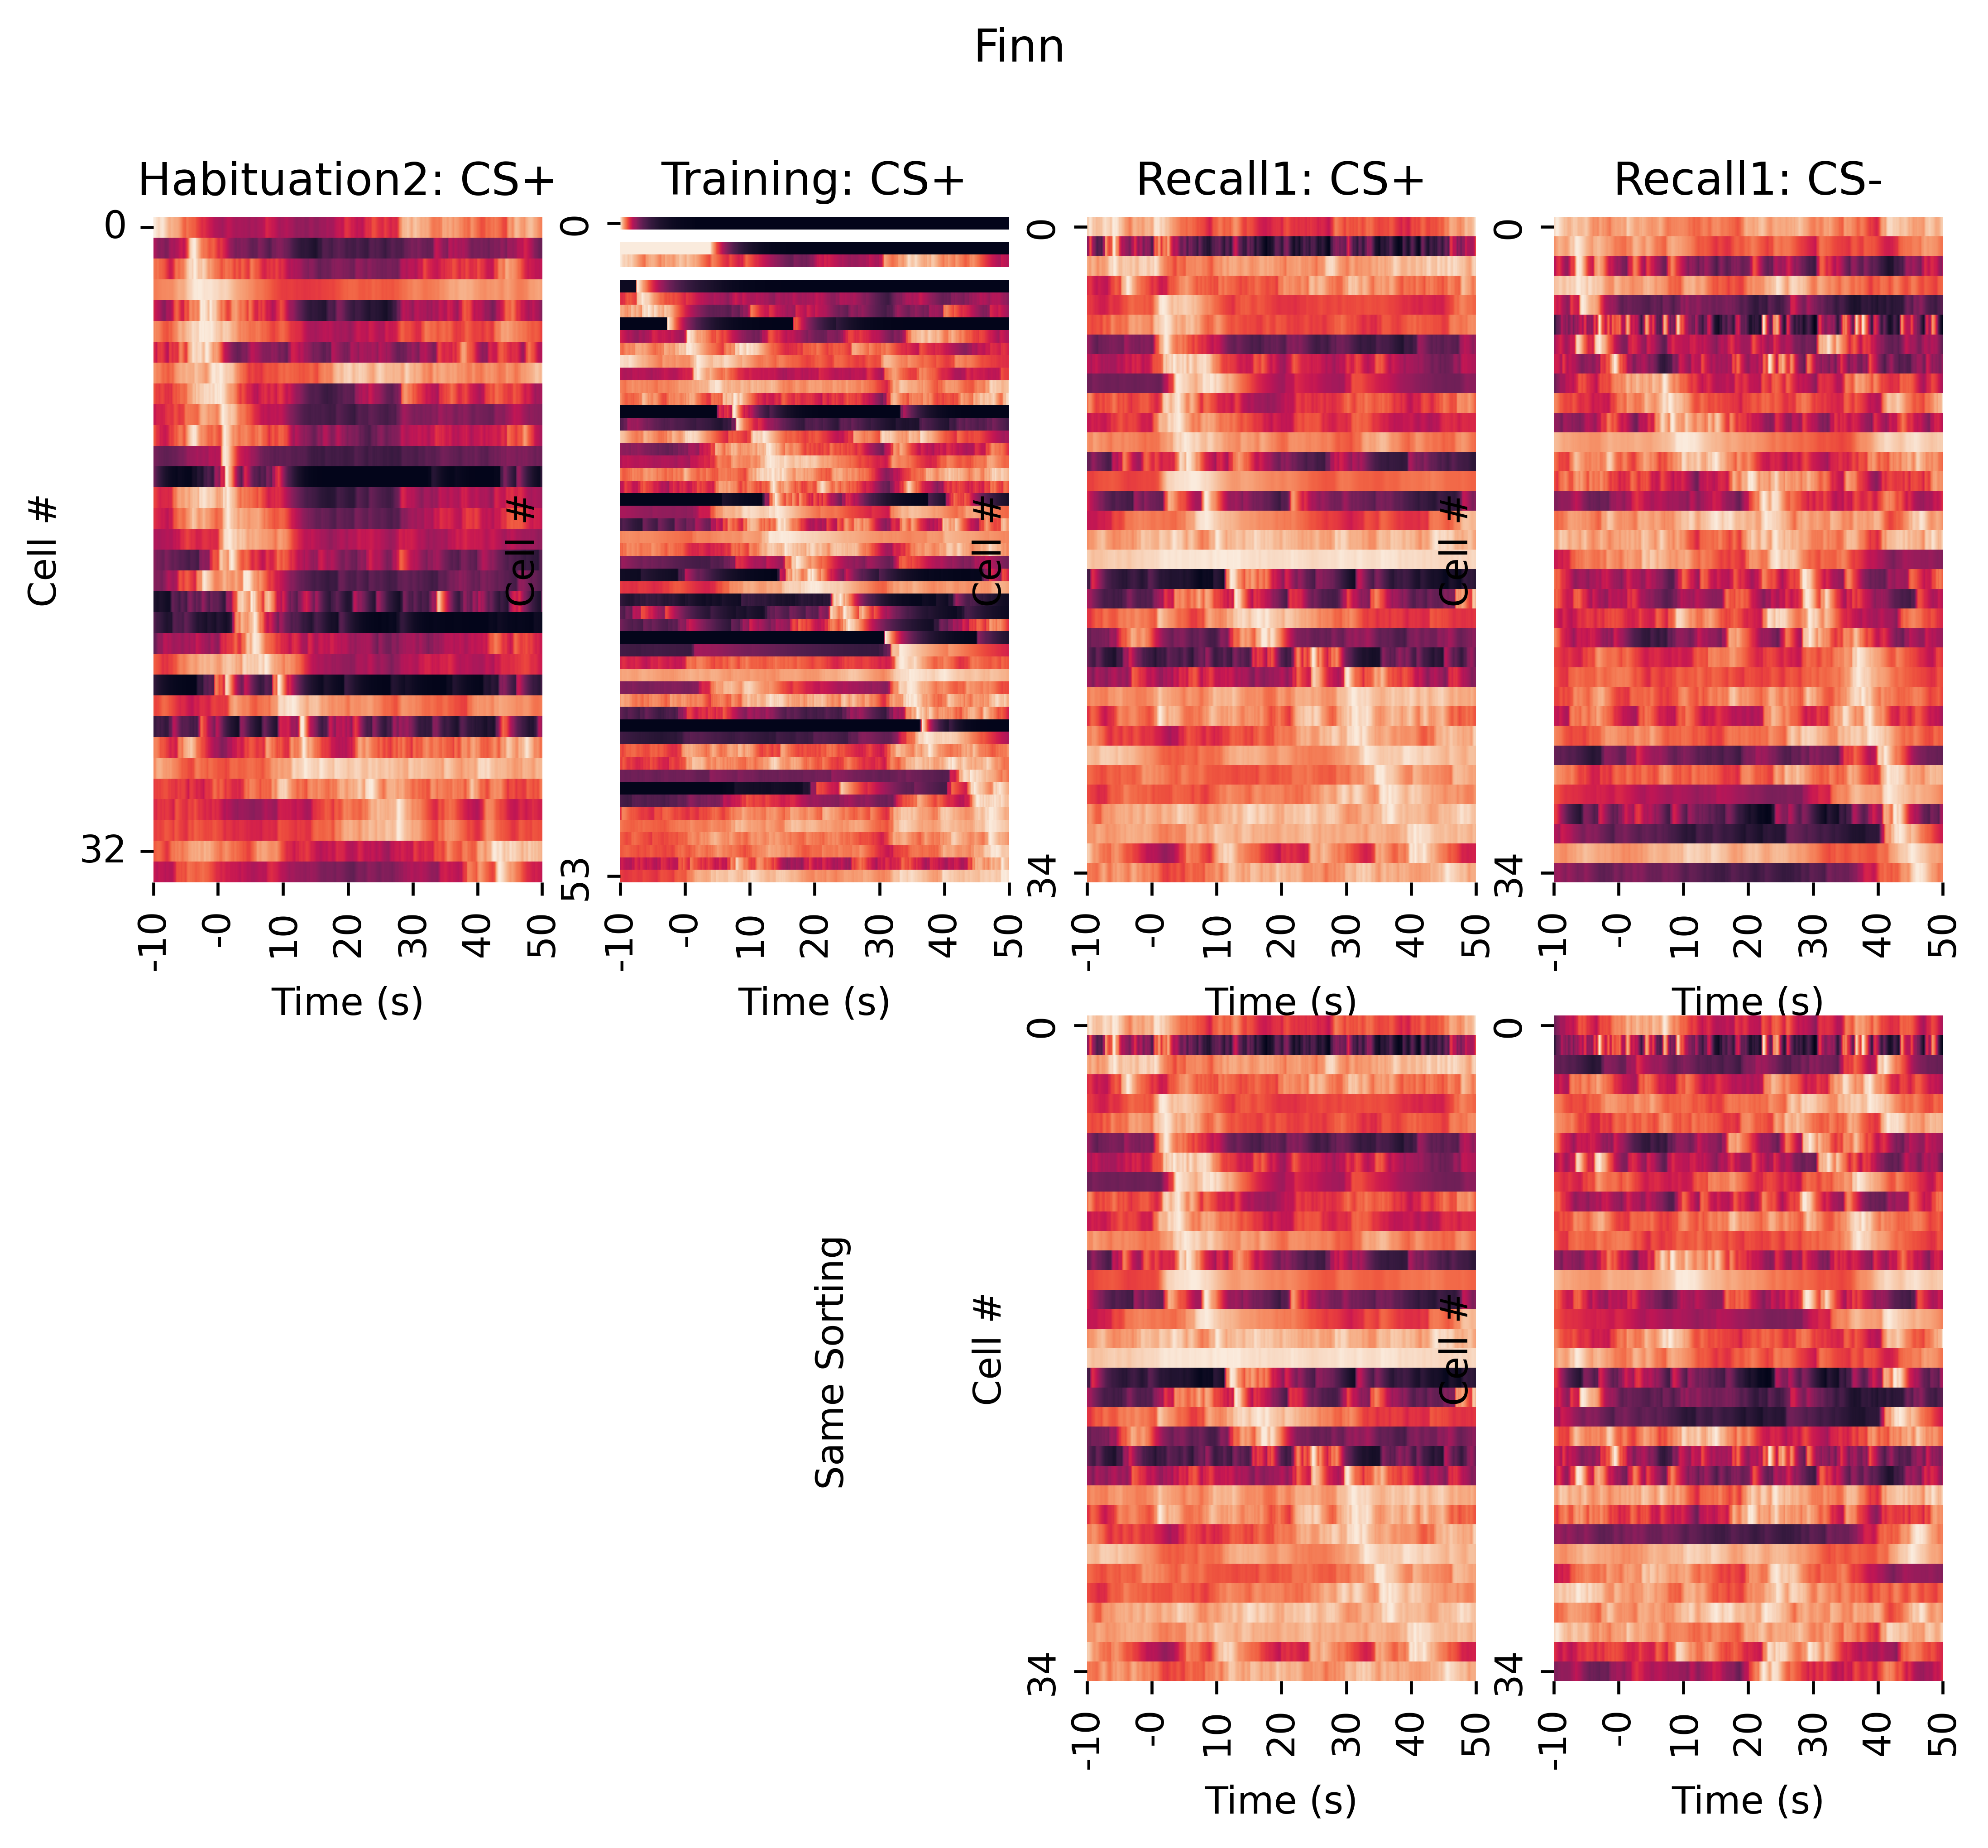

In [7]:
fig

## Attempt to match neurons across days

In [158]:
rastgroups

In [9]:
# Assemble maps
map_sessions = ['Habituation2', 'Training','Recall1']
msm = MultiSessionMap(pwmaps=[careg.load_pairwise_map(sesh1, sesh2) for sesh1, sesh2 in 
                       itertools.combinations(map_sessions, 2)], sesh_order=map_sessions)

# Get full map for all sessions
multi_sesh_map = msm.stepwise_reg(overwrite_indirect=True)

In [39]:
coactive2

0     False
1      True
2      True
3     False
4     False
      ...  
61    False
62     True
63     True
64     True
65     True
Length: 66, dtype: bool

In [43]:
coactive2 = np.sum(multi_sesh_map >= 0, axis=1) >= 2
multi_sesh_map[coactive2]

,Habituation2,Training,Recall1
1,1,-1,4
2,2,14,6
7,7,13,-1
8,8,16,-1
9,9,-1,9
10,10,17,11
12,12,21,16
13,13,-1,15
15,15,22,17
17,17,19,18


In [10]:
sesh1 = 'Habituation2'
sesh2 = 'Training'
sort_ids_use=sort_ids[np.where([sesh1 == sesh for sesh in sessions])[0][0]]
coactive_idx = np.array([np.where(sesh1_cell == multi_sesh_map[sesh1])[0][0] for sesh1_cell in sort_ids_use])
multi_sesh_map[sesh1].iloc[coactive_idx]

11    11
14    14
3      3
28    28
27    27
18    18
0      0
4      4
8      8
29    29
13    13
16    16
22    22
5      5
1      1
2      2
24    24
19    19
7      7
6      6
20    20
21    21
23    23
9      9
25    25
15    15
17    17
26    26
30    30
31    31
12    12
10    10
Name: Habituation2, dtype: int64

/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:502: RuntimeWarning: invalid value encountered in true_divide
  )


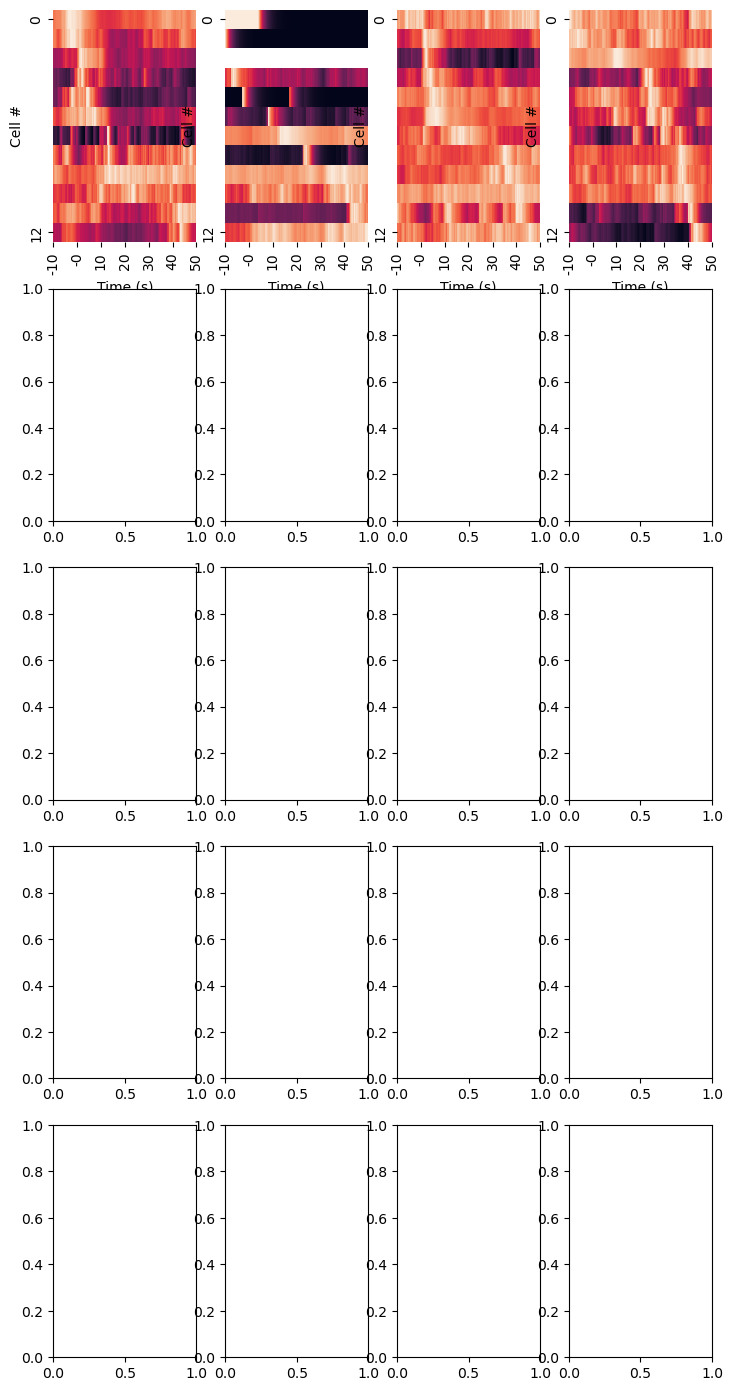

In [76]:
sesh1 = 'Habituation2'
coactive_all = np.all(multi_sesh_map >= 0, axis=1)
map_use = multi_sesh_map.loc[coactive_all, :]
map_use

_, ax = plt.subplots(5, 4, figsize=(8.5, 3.5*5))

sort_ids = []
for a, sesh2, rastgroup in zip(ax[0], sessions, rastgroups):
    coactive_cells = map_use[sesh2].values
    sort_id = rastgroup.cell_slice(coactive_cells).snake_plot(sortby="peak_time", ax=a, cbar=False, 
                                                              rasterized=True)
    sort_ids.append(sort_id)

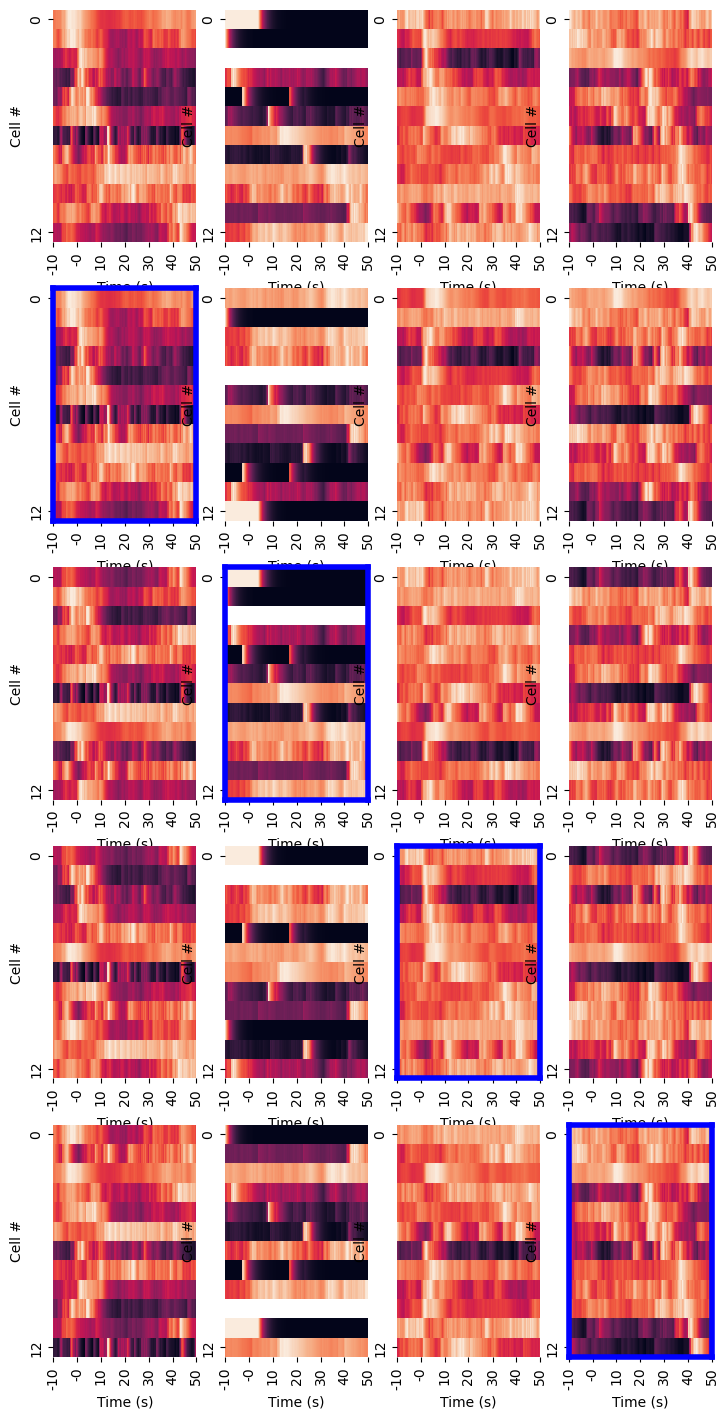

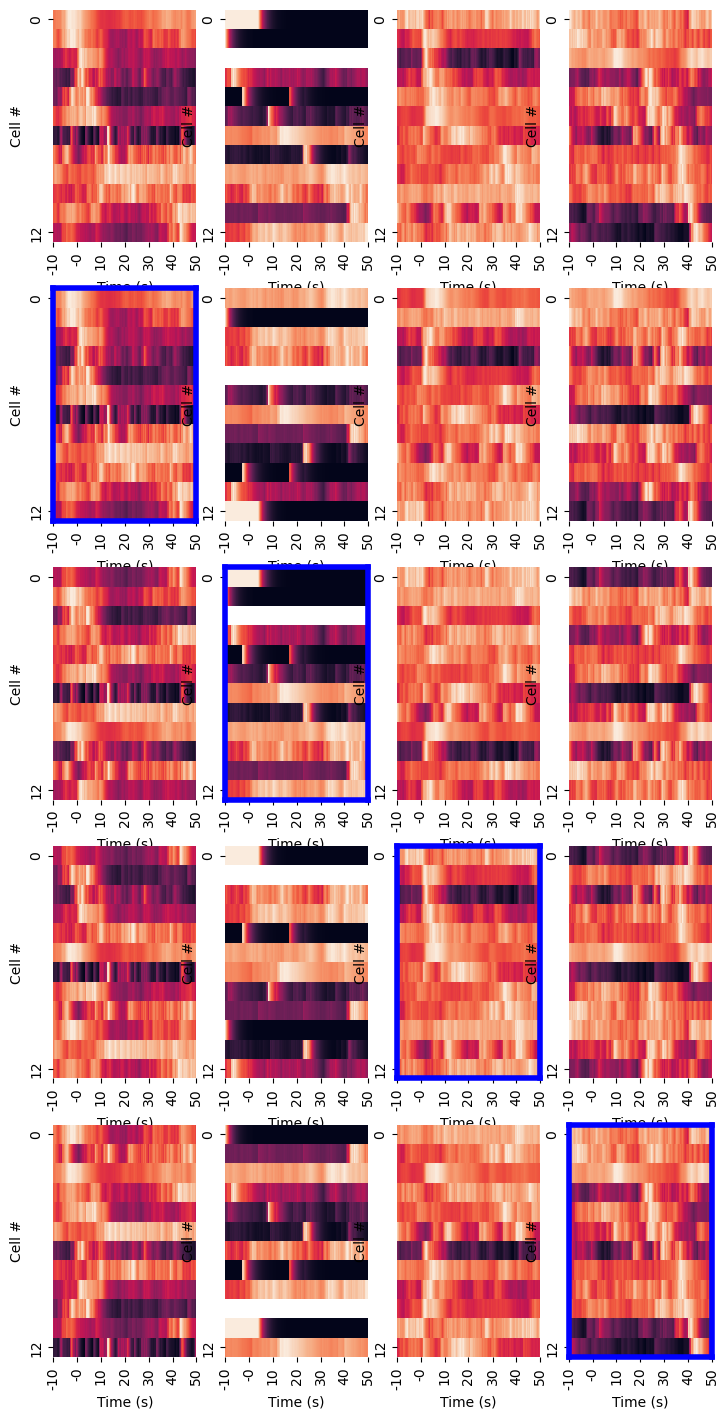

In [80]:
sesh1 = 'Habituation2'
coactive_all = np.all(multi_sesh_map >= 0, axis=1)
map_use = multi_sesh_map.loc[coactive_all, :]
map_use

_, ax = plt.subplots(5, 4, figsize=(8.5, 3.5*5))

sort_ids = []
# Plot first row sorting each session individually
for a, sesh2, rastgroup in zip(ax[0], sessions, rastgroups):
    coactive_cells = map_use[sesh2].values
    sort_id = rastgroup.cell_slice(coactive_cells).snake_plot(sortby="peak_time", ax=a, cbar=False, 
                                                              rasterized=True)
    sort_ids.append(sort_id)
    
# Now sort each row by a different session    
for sort_sesh_id  in [0, 1, 2, 3]:
    for a, sesh2, rastgroup in zip(ax[sort_sesh_id+1], sessions, rastgroups):
        coactive_cells = map_use[sesh2].values
        rastgroup.cell_slice(coactive_cells).snake_plot(sortby=sort_ids[sort_sesh_id], ax=a, cbar=False, 
                                                                  rasterized=True)
    # Highlight session you are sorting by!
    plt.setp(ax[sort_sesh_id+1][sort_sesh_id].spines.values(), color='b', linewidth=4)
    sns.despine(left=False, right=False, top=False, bottom=False, 
                ax=ax[sort_sesh_id+1][sort_sesh_id])
ax[0][0].figure

In [84]:
sesh2

'Recall1'

In [91]:
map_use.shape

(28,)

In [92]:
len(sort_id1)

34

In [93]:
multi_sesh_map

,Habituation2,Training,Recall1
0,0,-1,-1
1,1,-1,4
2,2,14,6
3,3,-1,-1
4,4,-1,-1
...,...,...,...
61,-1,45,-1
62,-1,46,27
63,-1,50,30
64,-1,51,31


/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:485: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sortby == "peak_time" or sortby == "trough_time":
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:47: RuntimeWarning: Mean of empty slice
  np.nanmean(self.raster, axis=0) if self.raster is not None else None
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:502: RuntimeWarning: invalid value encountered in true_divide
  sorted_mean_rast = sorted_mean_rast / sorted_mean_rast.max(axis=1)[:, None]


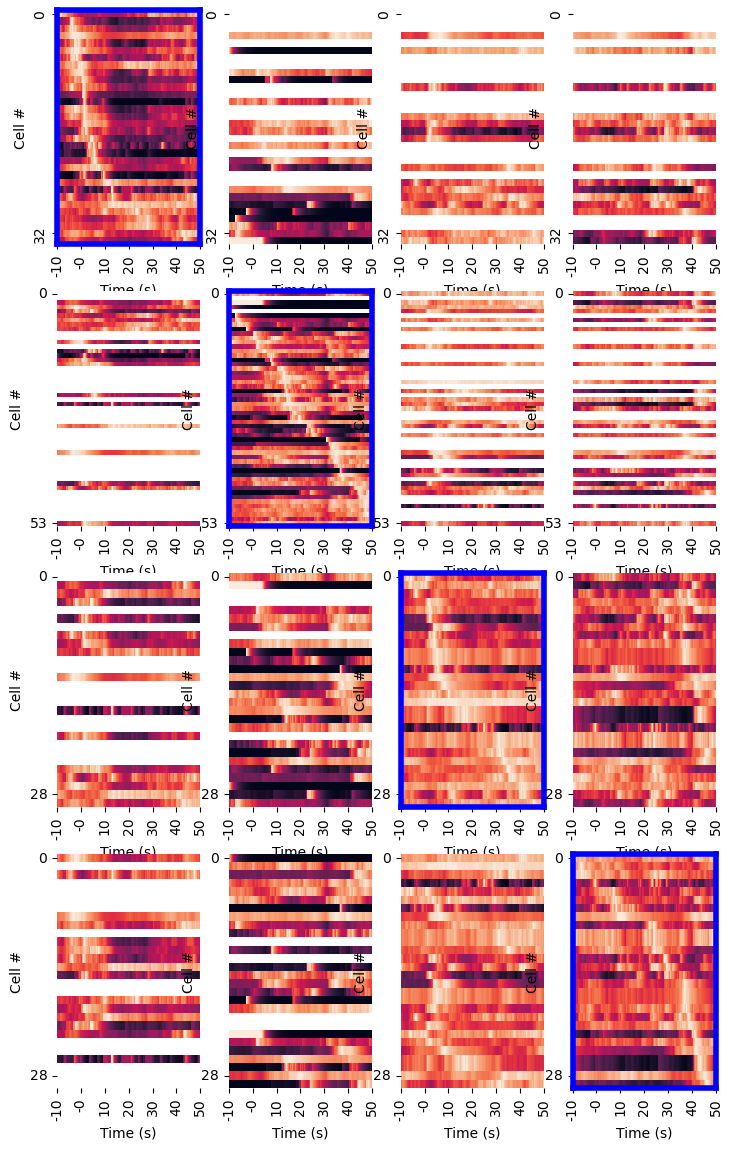

In [94]:
# This plots rasters with white lines for cells that aren't active in one session. 
# Hard to see things,.
figt, ax = plt.subplots(4, 4, figsize=(8.5, 3.5*4))
session_order = [0, 1, 2, 3]
for sesh1_id in range(len(sessions)):
    sesh1 = sessions[sesh1_id]
    map_self = multi_sesh_map[multi_sesh_map[sesh1] > -1][sesh1]
    sort_id1 = rastgroups[sesh1_id].cell_slice(map_self).snake_plot(sortby="peak_time", 
                                               ax=ax[sesh1_id][sesh1_id], 
                                               cbar=False, rasterized=True)
    sesh_reorder = np.roll(session_order, -sesh1_id)
    for sesh2_id in sesh_reorder:
        a = ax[sesh1_id][sesh2_id]
        sesh2 = sessions[sesh2_id]
        rastgroup = rastgroups[sesh2_id]
        map_use = multi_sesh_map[multi_sesh_map[sesh1] > -1][sesh2]
        rastgroup.cell_slice(map_use).snake_plot(sortby=sort_id1, ax=a, cbar=False, 
                                                                  rasterized=True)
    plt.setp(ax[sesh1_id][sesh1_id].spines.values(), color='b', linewidth=4)
    sns.despine(left=False, right=False, top=False, bottom=False, 
                    ax=ax[sesh1_id][sesh1_id])
    

In [157]:
msm.grab_map(['Habituation2', 'Training'])

,Habituation2,Training
0,0,-1
1,1,-1
2,2,14
3,3,-1
4,4,-1
5,5,-1
6,6,-1
7,7,13
8,8,16
9,9,-1


/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:544: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  def plot_pe_traces(
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:561: RuntimeWarning: invalid value encountered in true_divide
  :param activity: processed activity (e.g. C or S from CNMF_E) for one cell or all cells, same size as times


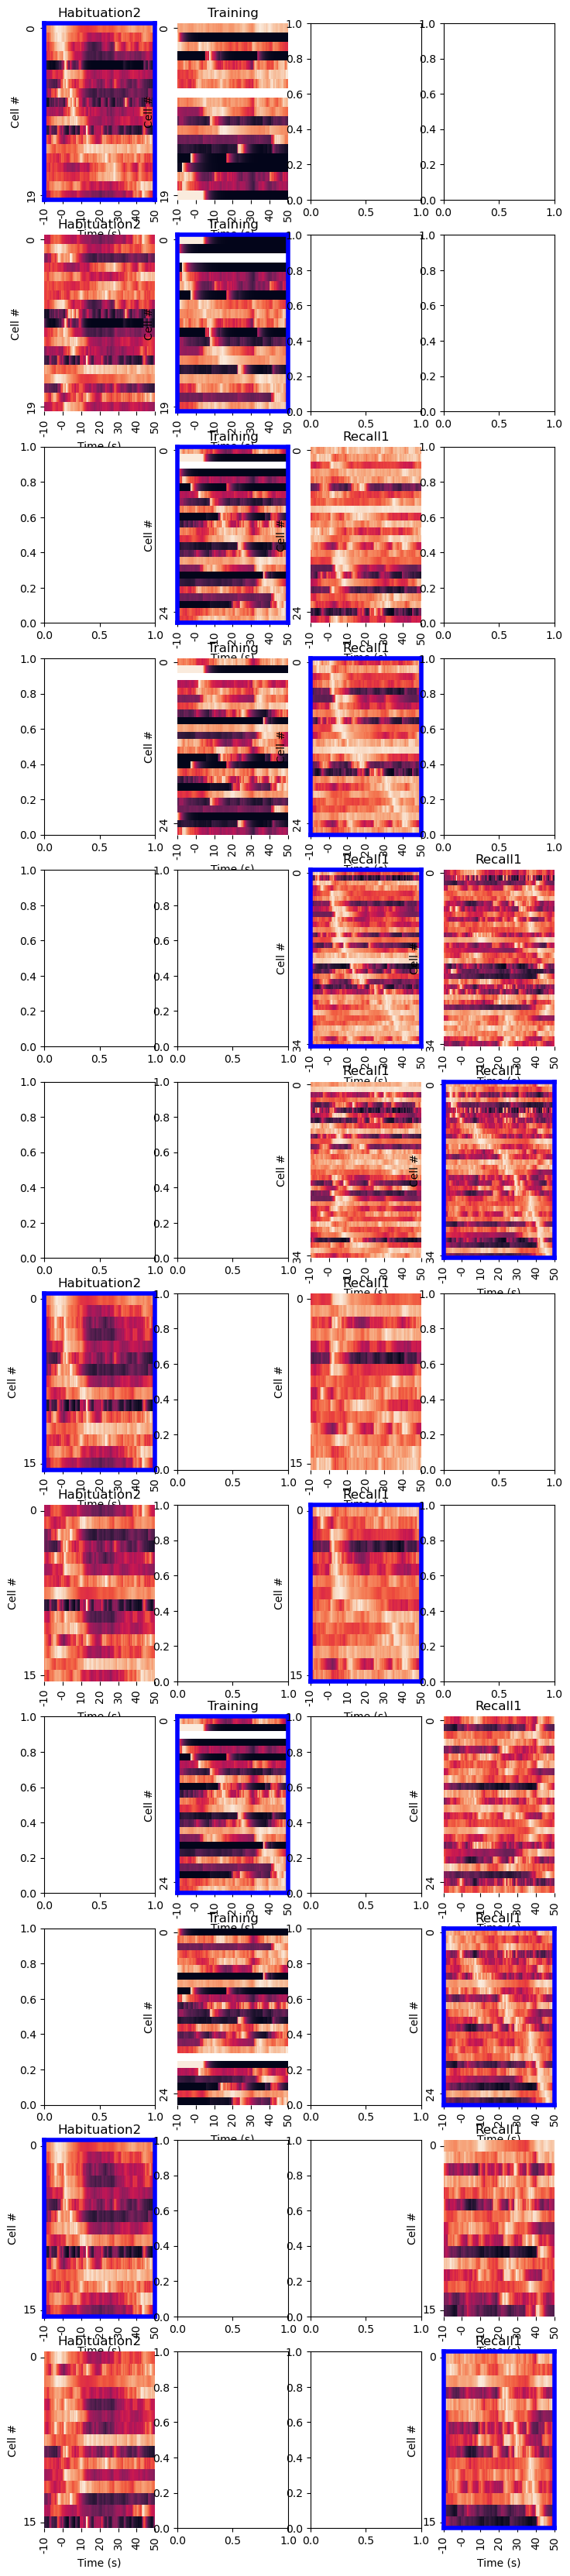

In [155]:
session_pairs = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [0, 2], [2, 0], 
                 [1, 3], [3, 1], [0, 3], [3, 0]]
figt, ax = plt.subplots(len(session_pairs), 4, figsize=(8.5, 3.5*len(session_pairs)))

for a, pair in zip(ax, session_pairs):
    sesh1, sesh2 = sessions[pair[0]], sessions[pair[1]]
    if sesh1 == sesh2:
        map_use = pd.DataFrame({sesh1: rastgroups[pair[0]].cell_ids})
    else:
        map_use = msm.grab_map([sesh1, sesh2], coactive_only=True)
    sort_id = rastgroups[pair[0]].cell_slice(map_use[sesh1].values).snake_plot(sortby="peak_time", 
                                                                     ax=a[pair[0]], 
                                                                     cbar=False, 
                                                                     rasterized=True)
    rastgroups[pair[1]].cell_slice(map_use[sesh2].values).snake_plot(sortby=sort_id, 
                                                           ax=a[pair[1]], cbar=False, 
                                                           rasterized=True)
    a[pair[0]].set_title(sesh1)
    a[pair[1]].set_title(sesh2)
    plt.setp(a[pair[0]].spines.values(), color='b', linewidth=4)
    sns.despine(left=False, right=False, top=False, bottom=False, ax=a[pair[0]])
                                                                            

In [156]:
figt.savefig(plot_save_dir / f'{animal}_{activity_type}_{sortby}_pairwise_snake_plot.pdf')

In [25]:
plot_save_dir = Path('/data2/Trace_FC/Recording_Rats/plots/snake_plots')
fig.savefig(plot_save_dir / f'{animal}_{activity_type}_{sortby}_snake_plot_rough.pdf')

In [ ]:
%%javascript
IPython.notebook.save_notebook()